<div style="text-align: left">
<img src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="800px">
</div>

# [RAMP](https://www.ramp.studio/problems/mechanics) on Mechanics determination

_Yetkin Yilmaz (LAL), Balazs Kegl (CDS, LAL)_

The goal of this challenge is to find ways to simulate the theoretical model finding process in physics or similar sciences. A good example is the paradigm shift between the Ptolemy and Copernican models of the universe.

In the challenge we start by putting ourselves in Ptolemy's shoes, approach the same problem in imaginary systems in which the motion of the objects in the sky could have completely different underlying mechanics that we don't know of.




<img src="http://ecuip.lib.uchicago.edu/multiwavelength-astronomy/images/gamma-ray/impact/ptolemy_cosmos.jpg" alt="Drawing" style="width: 700px;"/>

In the beginning, the task was simply to predict the future. Considering the early history of the birth of science, the capability of predicting the future was something that gave influential power to individuals; hence the investment of rulers to astrologers, and eventually to astronomers.

Scientific method was invented through this effort, marked by the Copernican revolution, which significantly boosted the predictive power of the models. While Ptolemy had a model that was able to (with sufficient amount of parameters) explain what has been observed, Copernican model was able to predict what came next.

In the terminology of ML, Ptolemy was able to achieve a good training score, but Copernicus was able to optimize training and test scores simultaneously. This observation led to the triumph of scientific method.

Inspired by this, we first focus on the regression problem, and then discuss how this leads to the formula classification to help solve it better.

The challenge consists of two parts: Classification and Regression. Both of these processes will also require Feature Extraction. The workflow can be briefly sketched as:




![](figures/workflow.png)

In this tutorial, we will discuss the workflow elements in reverse order: Regression, FE_Reg, Classification, FE_clf, in order to understand the motivations better. We consider the regression to be the absolute problem, and every step added before is a tool that eases the task of its successor.





## Regression problem

We will observe the angular position (phi) of the planet, and try to predict what this value will be in the future. The phi value takes values between [-$\pi$,$\pi$] and the error is not supposed to scale with the value, therefore we have chosen RMS error as the score metric.

## Data format

The main data is the time series of angles of a planet, observed from the point of reference (not necessarily an inertial frame). Although the motion of the planet might be something very different than what we know of, the motion is restricted to the two dimensional plane for sake of simplicity.




In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
# Main data format
data = pd.read_csv("data/train.csv")

print("shape : ", data.shape)
data.iloc[:, [0, 1, 2, 3, 197, 198, 199, -3, -2, -1]].head(10)

shape :  (2000, 203)


,0,1,2,3,197,198,199,system,distribution,future
0,-2.28861,-2.32769,-2.36418,-2.39483,-0.64168,-0.58043,-0.52136,A,10,1.59759
1,-0.81772,-0.80912,-0.81015,-0.82126,0.47328,0.51531,0.55769,B,10,2.48095
2,-2.80101,-2.77352,-2.74827,-2.72509,-1.48576,-1.59774,-1.72757,C,10,2.16330
3,0.72027,0.70516,0.69104,0.67807,-0.39239,-0.38015,-0.36906,D,10,-0.31700
4,-2.21660,-2.38328,-2.50315,-2.54693,2.63434,2.82065,3.00796,E,10,-2.31796
5,-0.80685,-0.88133,-0.98324,-1.12878,1.35864,1.47854,1.59853,A,10,0.64781
6,-0.39549,-0.30077,-0.21016,-0.12637,0.60743,0.65474,0.69851,B,10,3.04496
7,1.59870,1.64028,1.67922,1.71575,1.58182,1.59787,1.61437,C,10,-1.88389
8,0.71461,0.69830,0.68324,0.66962,0.10781,0.11378,0.11705,D,10,0.33476
9,0.65130,0.59862,0.55241,0.51424,2.66816,2.65499,2.64989,E,10,-1.22565


The indices on the horizontal axis represent time steps with equal intervals, can be considered as the unit of time. The values of phi for these times are listed. The "future" column represents the value of phi at 50 steps ahead. This is what we will try to predict in the regression problem. The "system" column represents one of the five mechanical systems (set of formulas) that was used to generate the time series. This will be the classification target. Each system comes with a bunch of "hyperparameters" which we draw randomly from a distribution. We will use different distributions which are indexed in the "distribution" column. This variable will be available both at training and test time, but it may have values in the test set not present in the training set. So this is not a target but not really a feature either, more like a "hint".

In [45]:
y_future = data['future'].values
y_system = data['system'].values
x_distribution = data['distribution'].values
x_series = data.drop(['future', 'system', 'distribution'], axis=1).values

In [46]:
x_series

array([[-2.28861, -2.32769, -2.36418, ..., -0.64168, -0.58043, -0.52136],
       [-0.81772, -0.80912, -0.81015, ...,  0.47328,  0.51531,  0.55769],
       [-2.80101, -2.77352, -2.74827, ..., -1.48576, -1.59774, -1.72757],
       ...,
       [ 0.21472,  0.2911 ,  0.37191, ...,  0.77008,  0.8217 ,  0.8726 ],
       [ 2.97809,  2.97429,  2.97902, ...,  2.7148 ,  2.80189,  2.89112],
       [ 2.85501,  2.83624,  2.84886, ...,  2.51329,  2.641  ,  2.76892]])

In [47]:
x_distribution

array([10, 10, 10, ..., 14, 14, 14])

In [48]:
y_system

array(['A', 'B', 'C', ..., 'C', 'D', 'E'], dtype=object)

In [49]:
y_future

array([ 1.59759,  2.48095,  2.1633 , ...,  2.39509, -1.35289,  0.67772])

## Fitting a single time series

Let's now pick one row and try to predict the future position of the planet by modeling the motion.
To illustrate the challenge better, we have some additional set of files with extra information, namely the 2D-positions of the planets involved.

In [50]:
file = "illustration"
data = pd.read_csv("data/" + file + "_phi.csv")

# Additional data items that are only for illustration:
data_x = pd.read_csv("data/" + file + "_x.csv")
data_y = pd.read_csv("data/" + file + "_y.csv")
ref_x = pd.read_csv("data/" + file + "_ref_x.csv")
ref_y = pd.read_csv("data/" + file + "_ref_y.csv")

In [51]:
def plot_observation(i_sample, t_min=0, t_max=200):
    phis = data.iloc[i_sample, range(t_max)].values[t_min:t_max]
    ax = plt.gca()
    ax.cla()
    ax.set_xlim([0, len(phis)])
    ax.set_ylim([-np.pi,np.pi])
    plt.xlabel('time')
    plt.ylabel('$\phi$')

    plt.scatter(range(len(phis)), phis)
    plt.plot(range(len(phis)), phis)
    plt.show()


In [52]:
def plot_orbit(i_sample, t_min=0, t_max=200):
    x = data_x.iloc[i_sample, range(t_max)].values[t_min:t_max]
    y = data_y.iloc[i_sample, range(t_max)].values[t_min:t_max]
    x0 = ref_x.iloc[i_sample, range(t_max)].values[t_min:t_max]
    y0 = ref_y.iloc[i_sample, range(t_max)].values[t_min:t_max]

    ax = plt.gca()
    ax.cla()
    xmax = np.amax(np.abs([x, y, x0, y0])) + 20

    ax.set_xlim([-xmax, xmax])
    ax.set_ylim([-xmax, xmax])
    plt.axes().set_aspect('equal')
    plt.scatter(x0, y0, color='r')
    plt.plot(x0, y0, color='r')
    plt.scatter(x, y)
    plt.plot(x, y)
    for i, t in enumerate(x):
        xl = np.array([x0[i], x[i]])
        yl = np.array([y0[i], y[i]])
        plot = plt.Line2D(xl, yl, color='k', linewidth=0.5, linestyle='dotted')
        ax.add_artist(plot)
    plt.show()



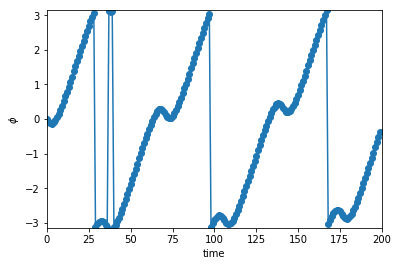

In [53]:
plot_observation(0)

/anaconda/envs/python-flow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


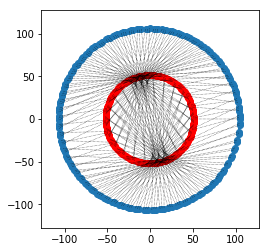

In [54]:
plot_orbit(0)

Notice that this is a single row of the dataset. With only the information in a single row, we can already make a prediction of the future, if we make some assumptions. For example...

In [55]:
# Function that returns the final angle of several epicycles joined successively
def f_phi(a, w, p, t):
    x = np.sum(a * np.cos(w * t + p))
    y = np.sum(a * np.sin(w * t + p))
    return np.arctan2(y, x)

In [56]:
# Look at the 0th row
phis = data.iloc[0, range(200)].values

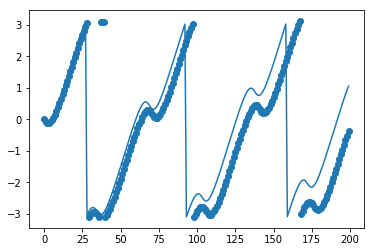

In [57]:
# Some initial guess of parameters by eye (and some knowledge of physics):
c_initial = np.array([51., 2.*np.sqrt(1./51.), np.pi, 105., np.sqrt(1./105.), 0.])

c = c_initial
a = c[0::3]
w = c[1::3]
p = c[2::3]

times = np.array(range(len(phis)))
phi_pred = [f_phi(a, w, p, i) for i in range(200)]

plt.scatter(times, phis)
plt.plot(times, phi_pred)
plt.show()

Now, let's fit the parameters to describe the function better:

In [58]:
def epicycle_error(c):
    a = c[0::3]
    w = c[1::3]
    p = c[2::3]
    phi_epi = [f_phi(a, w, p, i) for i in range(200)]
    return np.sum((np.unwrap(phis - phi_epi))**2)

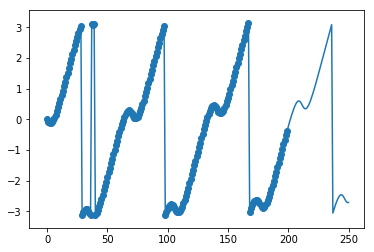

Fitted parameters :  [5.21092589e+01 2.69584554e-01 3.15340607e+00 1.07120115e+02
 9.13450445e-02 5.12794314e-03]


In [59]:
c = np.zeros(6)

use_cma = False
if(use_cma):
    import cma
    es = cma.CMAEvolutionStrategy(x0=c_initial, sigma0 = 0.001)
    es.optimize(epicycle_error)
    es.result_pretty()
    c = np.array(es.result.xbest).reshape(-1, 1)
else:
    from scipy.optimize import minimize
    res = minimize(fun=epicycle_error, x0=c_initial,
                   method='Nelder-Mead', tol=1e-10,
                   options={'xtol': 0.001, 'maxiter': 100000})
    c = res.x

a = c[0::3]
w = c[1::3]
p = c[2::3]

times = np.array(range(len(phis)))
phi_pred = [f_phi(a, w, p, i) for i in range(251)]

plt.plot(range(251), phi_pred)
plt.scatter(times, phis)
plt.show()

print("Fitted parameters : ", c)

The above is already what Copernican model would correctly describe. Let's now insist that the Mars is rotating in a bunch of epicycles around the earth, which are sucessively smaller. In order to do that, add more epicycles, and L1 regularization to kill those that are not needed. Below is a time-expensive computation, not recommended for the analysis of the full dataset.
Since the functions involved are differentiable, it is perhaps possible to implement a faster method for optimization, e.g. gradient descent. An example is in the example: submissions/tf_ptolemy/

In [60]:
def epicycle_error_l1reg(c):
    a = c[0::3]
    w = c[1::3]
    p = c[2::3]
    phi_epi = [f_phi(a, w, p, i) for i in range(200)]
    return np.sum((np.unwrap(phis - phi_epi))**2) + 0.1 * np.sum(np.abs(a))

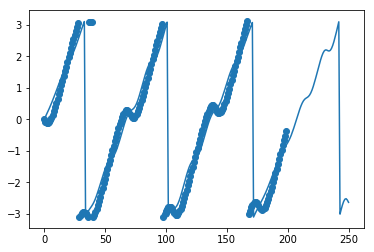

Fitted parameters :  [-1.92887954e-01  3.70954366e-02  1.39746208e-02  1.66507449e+01
  8.83398752e-02 -9.22094869e-03  1.44290912e+00  4.78525840e-01
  4.72772710e-03  8.45257314e+00  9.81775574e-02  4.72057801e-03
 -2.27068345e+00  4.44083059e-01  1.76264295e-03]


In [61]:
#c_overfit = np.tile(c_initial, 3)
c_overfit = np.array([51., 0.3, 0., 
                      10., 0.1, 0.,
                      10., 0.5, 0.,
                      5., 0.1, 0.,
                      5., 0.5, 0.,
                     ])

c = np.zeros(18)

use_cma = False
if(use_cma):
    import cma
    es = cma.CMAEvolutionStrategy(x0=c_overfit, sigma0 = 0.001)
    es.optimize(epicycle_error)
    es.result_pretty()
    c = np.array(es.result.xbest).reshape(-1, 1)
else:
    from scipy.optimize import minimize
    res = minimize(fun=epicycle_error_l1reg, x0=c_overfit,
                   method='Nelder-Mead', tol=1e-10,
                   options={'xtol': 0.001, 'maxiter': 10000})
    c = res.x


a = c[0::3]
w = c[1::3]
p = c[2::3]

times = np.array(range(len(phis)))
phi_pred = [f_phi(a, w, p, i) for i in range(251)]

plt.scatter(times, phis)
plt.plot(range(251), phi_pred)
plt.show()

print("Fitted parameters : ", c)

Let's see whether LSTM can predict that far ahead... 

In [62]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [63]:
n_train = 100
n_time = 50
phi_short = np.ndarray(shape=(n_train, n_time, 1))

for i in range(0, n_train):
    phi_short[i, :, 0] = phis[i:i + n_time] / np.pi

target =  phis[n_time + 50:] / np.pi
inputs = Input(shape=(n_time, 1), dtype='float', name='main_input')
layer = LSTM(12)(inputs)
predictions = Dense(1)(layer)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='mean_squared_error')

model.fit(phi_short, target, epochs=8, batch_size=1, verbose=2)

Epoch 1/8
 - 4s - loss: 0.2824
Epoch 2/8
 - 3s - loss: 0.1742
Epoch 3/8
 - 3s - loss: 0.1123
Epoch 4/8
 - 3s - loss: 0.0788
Epoch 5/8
 - 3s - loss: 0.0574
Epoch 6/8
 - 3s - loss: 0.0613
Epoch 7/8
 - 3s - loss: 0.0574
Epoch 8/8
 - 3s - loss: 0.0462


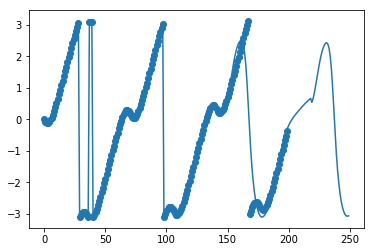

In [64]:
x_pred = np.ndarray(shape=(250, n_time, 1))
for i in range(0, 150):
    x_pred[i, :, 0] = phis[i:i + n_time] / np.pi

for i in range(150, 250):
    x_pred[i, :, 0] = model.predict(x_pred[i - n_time - 50].reshape(1, 50, 1))[0]

plt.scatter(times, phis)
plt.plot(range(250), x_pred[:, 0, 0] * np.pi)
plt.show()

# The challenge

Notice that this was a single row in a dataset.
The challenge is to do this analysis for each row separately. Each row in the dataset is another physics system with unknown dynamics, and randomized initial state, for which the participants are to determine the relevant model first and re-fit for row-specific parameters.



The classification task substitutes for the formula finding part of the theoretical study, except instead of an infinite set of possibilities, we simplify the problem into a limited set of formulas.

The dataset now consists of alternative physics/mechanics scenarios, in which some formulas/dynamics are made up. We put ourselves in the shoes of Ptolemy and try to model the angular motion of the observed objects without knowing what causes such behavior.

The participant can follow many different strategies. Some examples are provided, which are explained below, but any solution that returns the right classification and regression results is fine.

## Using feature extractor to simplify data 

The above process could be performed either inside the predict() function, or, it can be performed in a transform() function in feature_extractor such that the data is now represented more efficiently and further regression methods can be applied to gain better accuracy.
In the available examples, most of the stuff happens in the feature_extractor_reg, and predict is only the identity function.

## Classification problem and score

Although so far  the classification part of the problem has been described as a helpful side task, it is essential to the main motivation of this challenge: Invent theoretical models in science.

Ideally, we would like to find the best functions that describe the data. In this challenge, we simplified this effort by assuming that the first step in generating the formula is to be able to classify a dataset into a set of given formulas. 

As the formula space is extended, the problem gets similar to theory generation.


## starting_kit : Simple ML model

The starting kit is basically a template for all the functions to be implemented. It attempts to solve the classification and regression problems without any knowledge of the context and the discussion above. You can use this example to start implementing your own approach from complete scratch.

## Ptolemian model

submissions/ptolemy is an example that incorporates the above formula modeling into a proper submission. The actual fitting happens in the feature_extractor_reg, from which the predicted value is passed on to the regressor directly. 

### Tensorflow version for advanced optimization

submissions/tf_ptolemy is the same approach as above, but implemented with tensorflow eager execution. The participants may work on an optimization strategy using gradient calculations.

In [ ]:
from submissions.tf_ptolemy.feature_extractor_reg import *

In [ ]:
n_epicycle = 100
model = Ptolemy(n_epicycle)
model.assign_parameters(
                pars=np.array([1., 0.08284271, 3.14159265] * n_epicycle))

times = np.arange(0., len(phis))
epochs = range(1000)
for epoch in epochs:
    model.train(times, phis, rate=0.01)

c = model.c.numpy()
a = c[0::3]
w = c[1::3]
p = c[2::3]

phi_pred = np.array(model(np.arange(0., len(phis) + 50))).reshape(-1)

plt.scatter(times, phis)
plt.plot(range(250), phi_pred)
plt.show()

## Copernican model

submissions/tf_copernicus is the same as tf_ptolemy, except it is restricted to only 2 circles and without regularization, it tries to fit the observed motion of Mars from Earth analytically. It only succeeds for system A.

## Newtonian model

submissions/tf_newton is an actual pysics model that simulates the motion in discrete time steps, for a given force formulation.

## LSTM model

## Scoring

Although there are two scores involved, we want to set the regression as the main score and treat the classification problem as a side product of the optimization for regression. We want, however, the participants to at least submit a non-trivial solution for classification therefore we assign a small but non-zero proportion for the combined score. For the regression, RMS-error is used, which is wrapped around pi and -pi.

## Local testing/exploration

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

Check list

- Make sure you have installed `ramp-workflow` locally (see [above](#Installation-of-ramp-workflow))
- Make sure that the python files `object_detector.py` is in the  `submissions/your_submission` folder, and the train and test data are in [`data`](/tree/data)
- If you haven't yet, download the images by executing 
  ```
  python download_data.py
  ```

Finally, make sure the local processing goes through by running the

```
ramp_test_submission --submission your_submission
```

If you want to quickly test the that there are no obvious code errors, use the `--quick-test` keyword to only use data from the first 30 images. 

```
ramp_test_submission --submission your_submission --quick-test
```

In [22]:
!ramp_test_submission --quick-test

Testing Mechanics classification
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
/anaconda/envs/python-flow/lib/python3.6/site-packages/sklearn/decomposition/pca.py:423: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/anaconda/envs/python-flow/lib/python3.6/site-packages/sklearn/decomposition/pca.py:423: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/anaconda/envs/python-flow/lib/python3.6/site-packages/sklearn/decomposition/pca.py:423: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/anaconda/envs/python-flow/lib/python3.6/site-packages/sklearn/decomposition/pca.py:423: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
	score    err   rmse  combined
	train  0.000  0.000     0.000
	valid 

If you get to see the train and test scores, and no errors, then you can submit your model to the ramp.studio.

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit them to [ramp.studio](https://www.ramp.studio). First, if it is your first time using RAMP, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then find an open event on the particular problem, the event [mars_craters](https://www.ramp.studio/events/mars_craters_cifar) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](https://www.ramp.studio/events/mechanics/sandbox) and copy-paste (or upload) your files. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](https://www.ramp.studio/events/mechanics/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](https://www.ramp.studio/events/mechanics/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](https://www.ramp.studio/events/mechanics/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints scores for each cross-validation fold
```
        score    err   rmse  combined
        train  0.000  1.174     1.057
        valid  0.143  1.107     1.010
        test   0.091  1.132     1.028
```
and the mean cross-validation score at the end 
```
----------------------------
Mean CV scores
----------------------------
        score          err         rmse     combined
        train    0.0 ± 0.0  1.174 ± 0.0  1.057 ± 0.0
        valid  0.143 ± 0.0  1.107 ± 0.0   1.01 ± 0.0
        test   0.091 ± 0.0  1.132 ± 0.0  1.028 ± 0.0
```

The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](https://www.ramp.studio/events/mechanics/leaderboard)) is the mean average precision AP, that is the area under the precision/recall curve. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=mechanics ramp).

# Appendix: Visualize some example systems

In [34]:
file = "illustration"
data = pd.read_csv("data/" + file + "_phi.csv")

# Additional data items that are only for illustration:
data_x = pd.read_csv("data/" + file + "_x.csv")
data_y = pd.read_csv("data/" + file + "_y.csv")
ref_x = pd.read_csv("data/" + file + "_ref_x.csv")
ref_y = pd.read_csv("data/" + file + "_ref_y.csv")

In [35]:
def plot_data(i, t_min=0, t_max=200):
    plot_orbit(i, t_min, t_max)
    plot_observation(i, t_min, t_max)

In [ ]:
for i in range(len(data.index)):
    plot_data(i, 0, 200)